In [1]:
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pylab import rcParams

from mlforecast import MLForecast

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from src.data.loaders import CommodityLoader
from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)

In [3]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [4]:
train, val, test = split_series(df_brl)
full_train = pd.concat([train, val])

lags = [1,2,3,4,5,6,7,8,9,10,11,12]

evaluator = MetricEvaluator()

Treino + Val ACUCAR_SANTOS: 45 | Teste ACUCAR_SANTOS: 20
Treino + Val ACUCAR_SP: 185 | Teste ACUCAR_SP: 80
Treino + Val ALGODAO: 243 | Teste ALGODAO: 105
Treino + Val ARROZ: 168 | Teste ARROZ: 72
Treino + Val CAFE_ARABICA: 241 | Teste CAFE_ARABICA: 104
Treino + Val CAFE_ROBUSTA: 201 | Teste CAFE_ROBUSTA: 87
Treino + Val MILHO: 175 | Teste MILHO: 75
Treino + Val SOJA_PARANA: 234 | Teste SOJA_PARANA: 101
Treino + Val SOJA_PARANAGUA: 161 | Teste SOJA_PARANAGUA: 70
Treino + Val TRIGO_PARANA: 179 | Teste TRIGO_PARANA: 77
Treino + Val TRIGO_RS: 179 | Teste TRIGO_RS: 77
Splitted data into TRAIN with size 1605, VALIDATION with size 406 and TEST with size 868


### Raw

In [5]:
model = make_pipeline(
    MinMaxScaler(feature_range=(0, 1)),
    RandomForestRegressor(
        n_estimators=5,
        min_samples_leaf=5,
        max_depth=5,
    )
)

fcst = MLForecast(
    models={'rf': model},
    lags=lags,
    freq='MS'
)

# params found here https://www.nature.com/articles/s41598-024-74503-4/tables/7

In [6]:
fcst.fit(full_train)

MLForecast(models=[rf], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [7]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [8]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [9]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['rf'],         
    groupby_column='unique_id'     
)

print(results)

         unique_id Model  n_observations         MAE      MAPE           MSE  \
0    ACUCAR_SANTOS    rf              20    7.731002  0.053315    102.837638   
1        ACUCAR_SP    rf             100    5.061192  0.049484     38.764192   
2          ALGODAO    rf             205   13.222785  0.038239    442.369759   
3            ARROZ    rf             277    2.867616  0.050767     16.610752   
4     CAFE_ARABICA    rf             381   57.140886  0.042522  47267.307759   
5     CAFE_ROBUSTA    rf             468   55.496398  0.126981  15279.213851   
6            MILHO    rf             543    2.742387  0.063077      9.465885   
7      SOJA_PARANA    rf             644    3.454162  0.043659     16.227379   
8   SOJA_PARANAGUA    rf             714    9.992982  0.114589    105.084790   
9     TRIGO_PARANA    rf             791  119.439701  0.115120  35618.520964   
10        TRIGO_RS    rf             868   76.313559  0.075658  22400.760694   

          RMSE        R2  
0    10.1408

In [10]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
          MAE                                      MAPE                        \
         mean      std     min       max median    mean    std     min    max   
Model                                                                           
rf     32.133  39.3249  2.7424  119.4397  9.993  0.0703  0.033  0.0382  0.127   

                      MSE                                               RMSE  \
       median        mean         std     min         max    median     mean   
Model                                                                          
rf     0.0533  11027.0149  17031.7342  9.4659  47267.3078  105.0848  67.1135   

                                               R2                          \
           std     min       max   median    mean     std     min     max   
Model                                                                       
rf     84.7058  3.0767  217.4105  10.2511  0.6613  0.3644 -0.0142  0.9723   

               


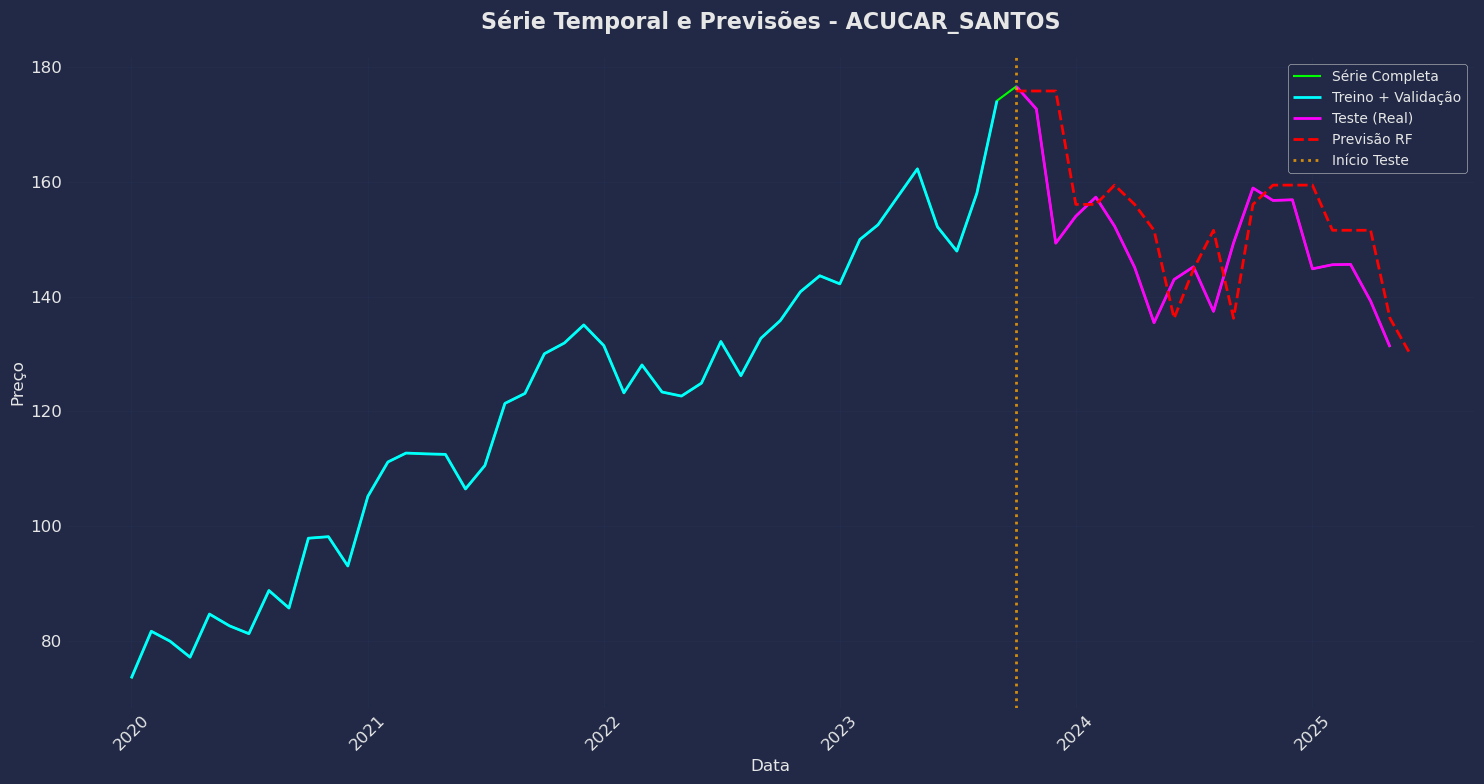

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


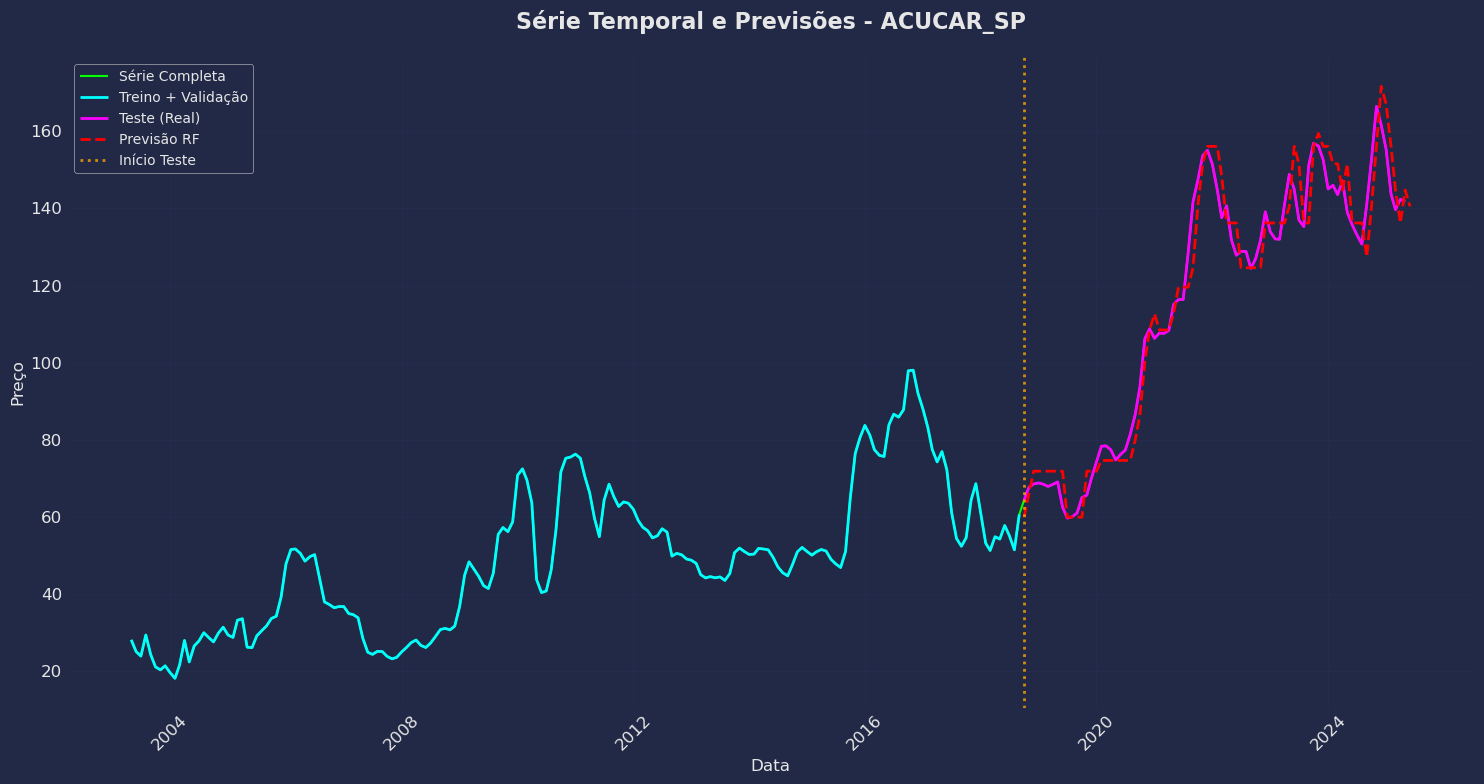

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


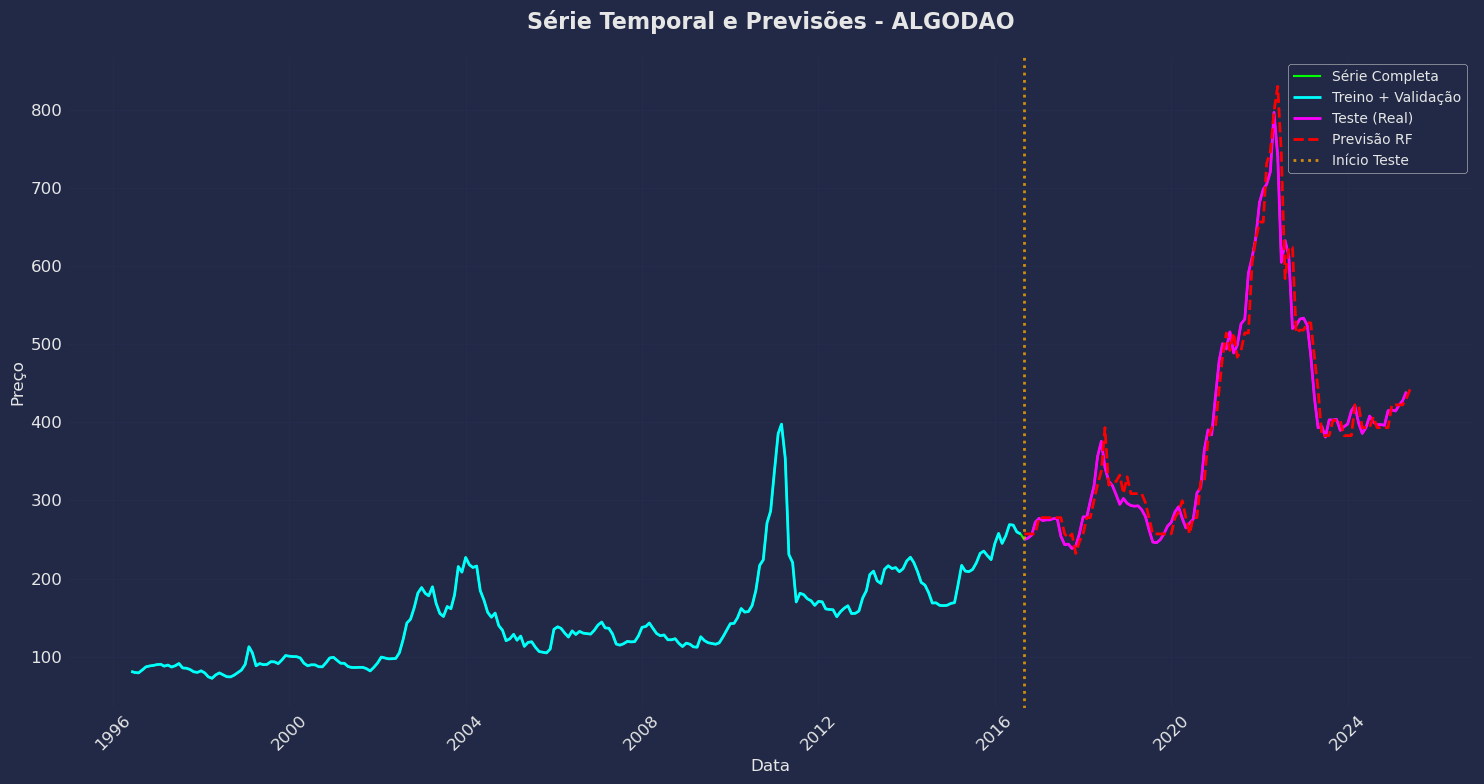

Gráfico exibido para: ALGODAO
--------------------------------------------------


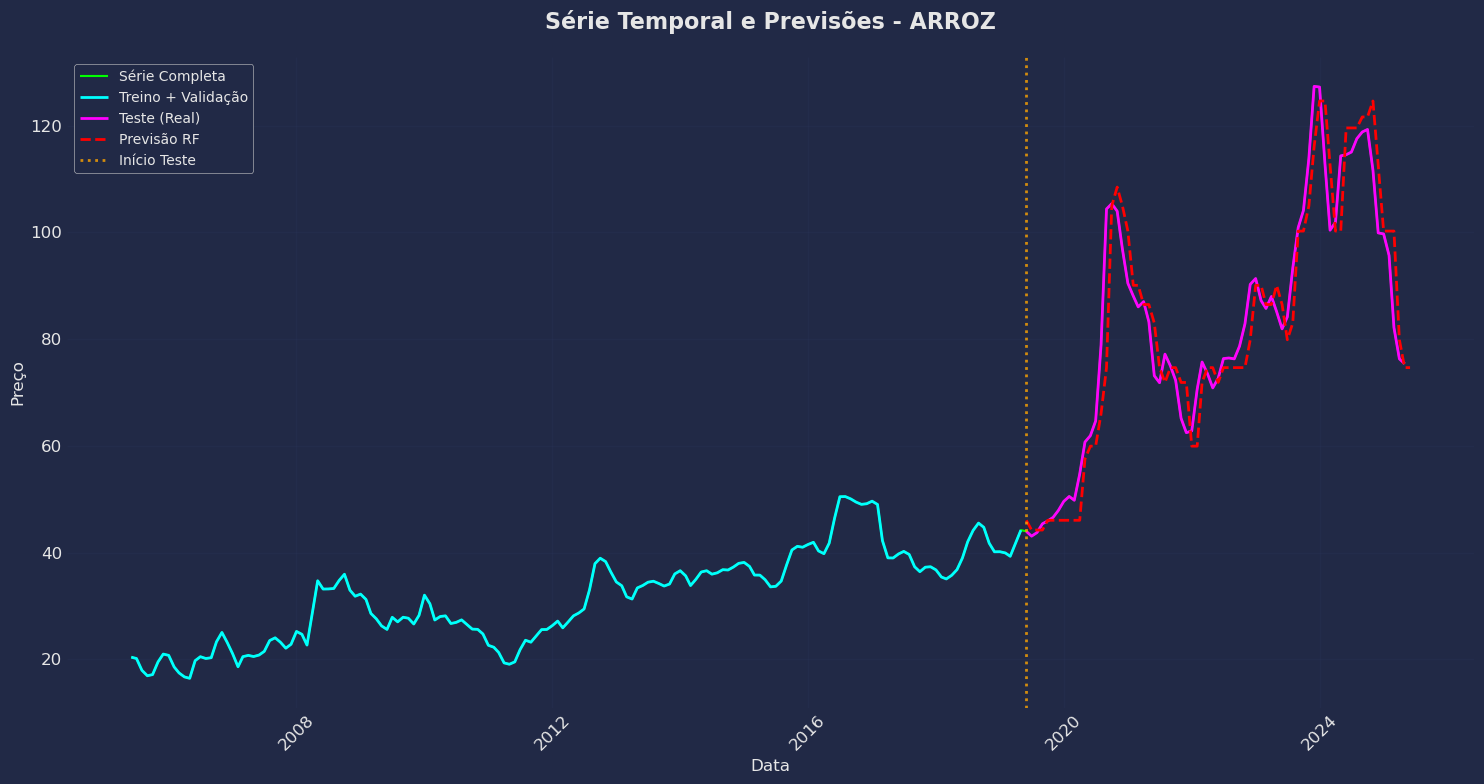

Gráfico exibido para: ARROZ
--------------------------------------------------


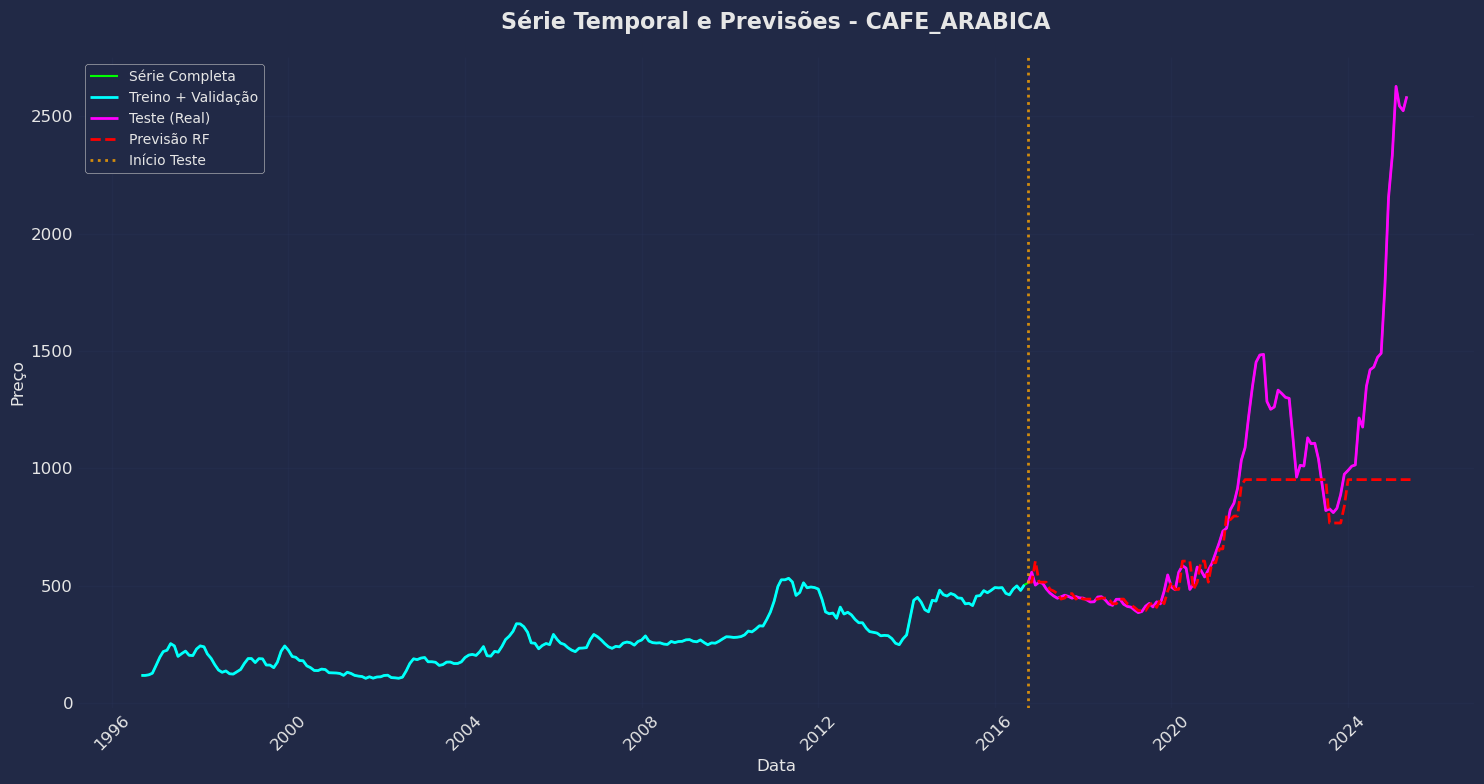

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


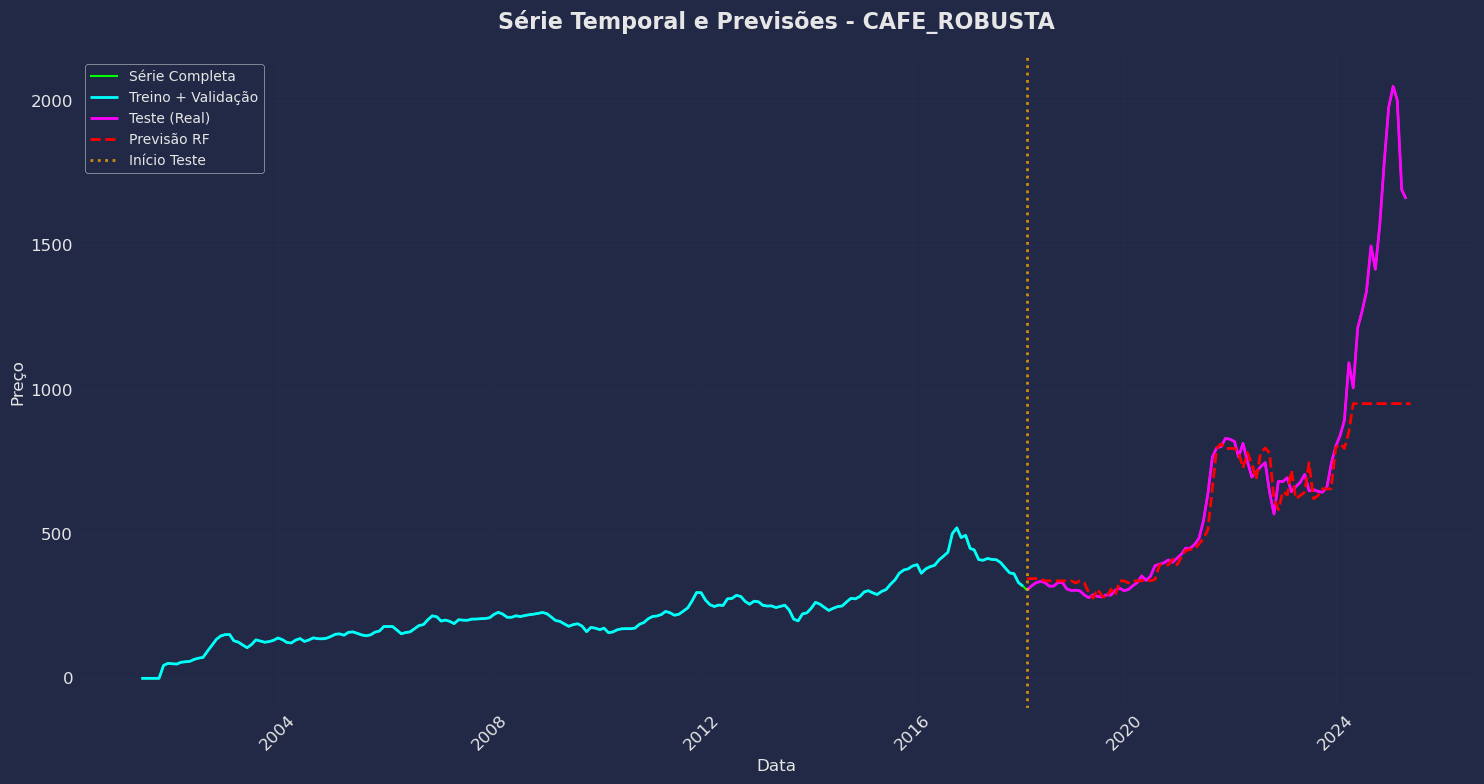

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


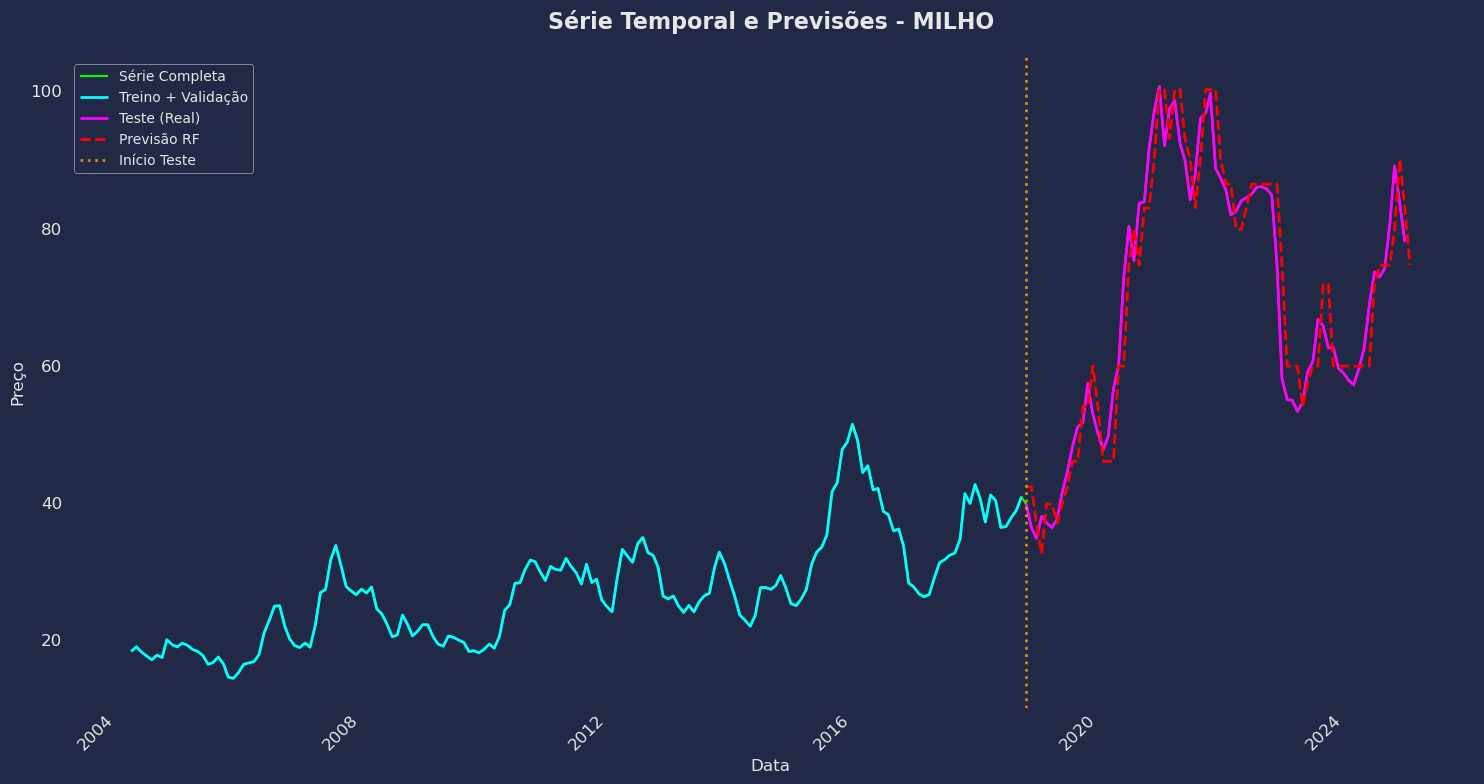

Gráfico exibido para: MILHO
--------------------------------------------------


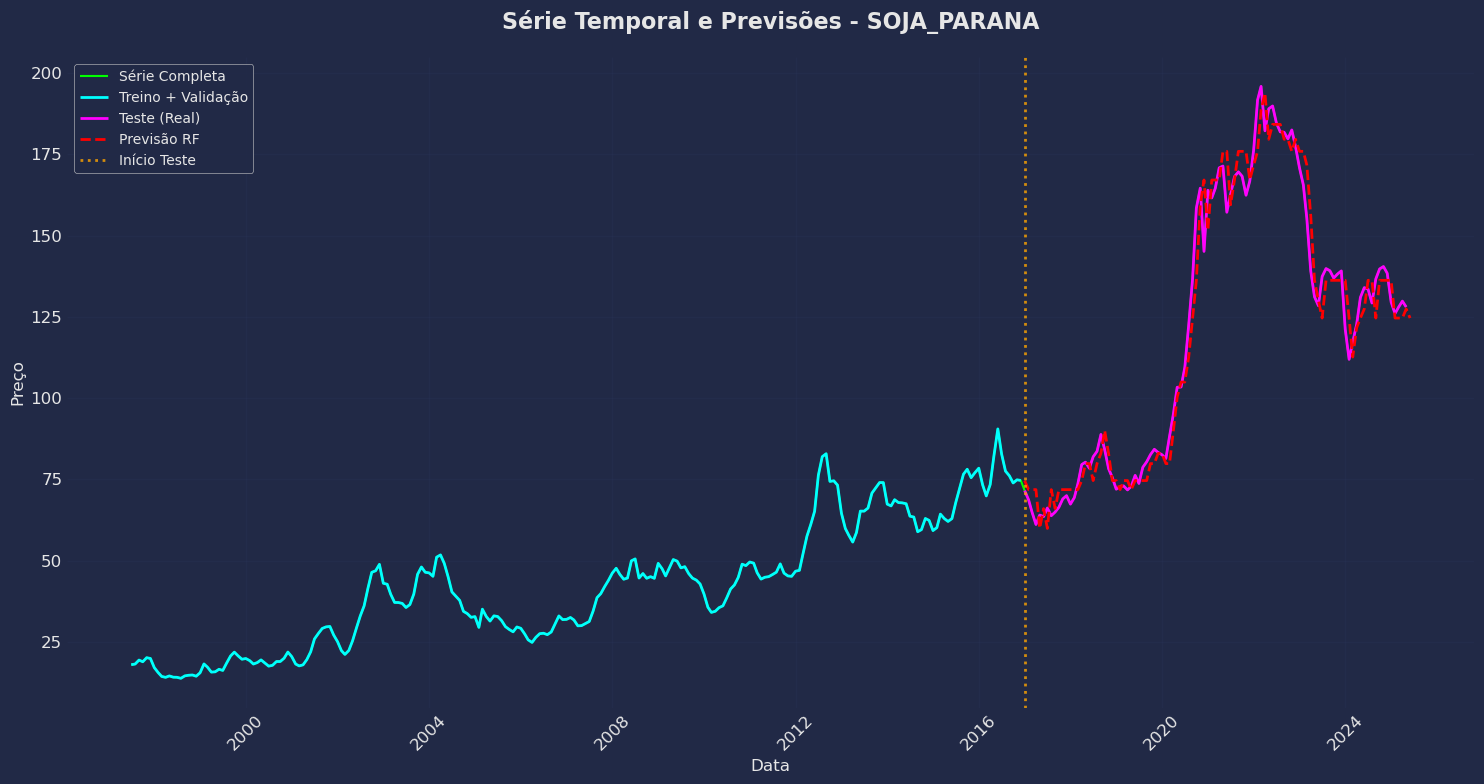

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


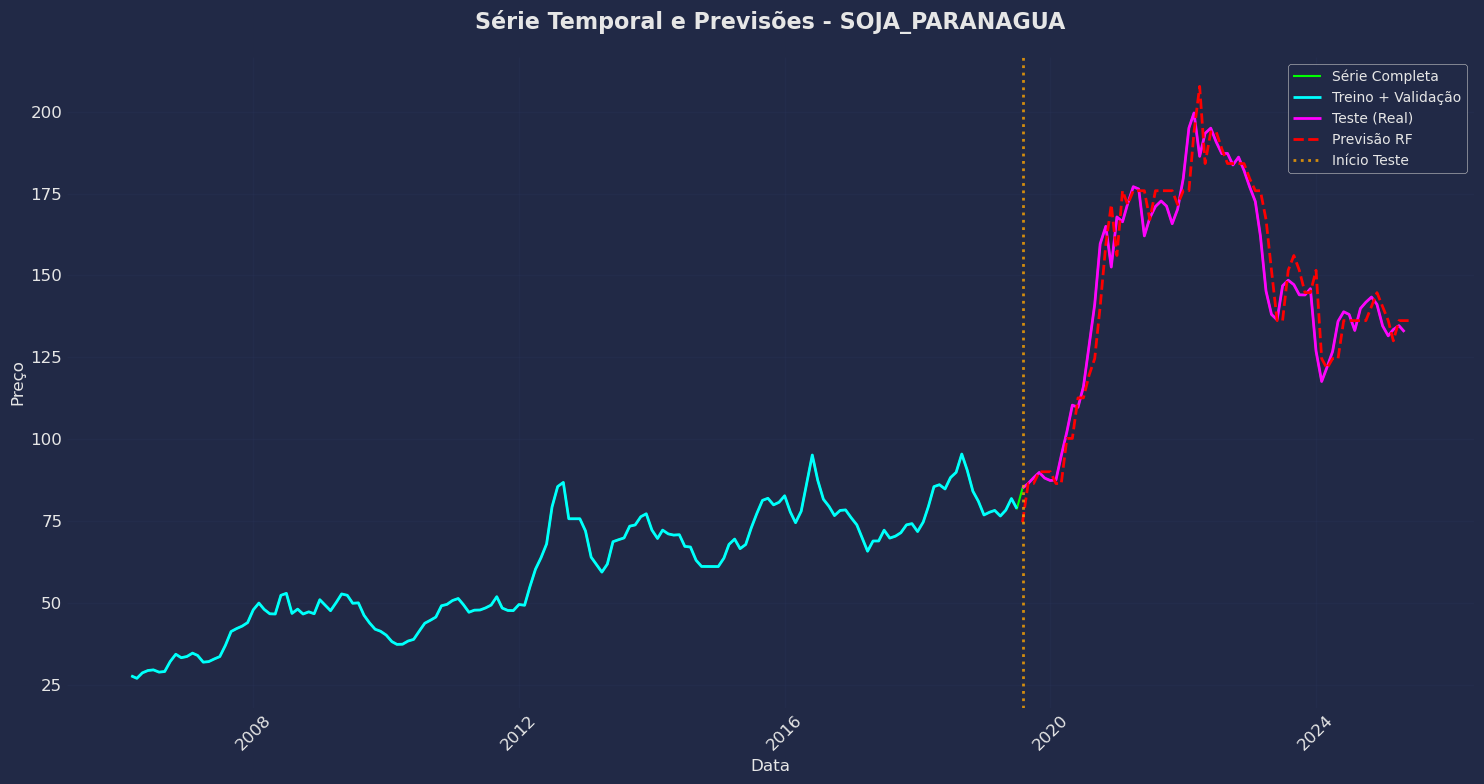

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


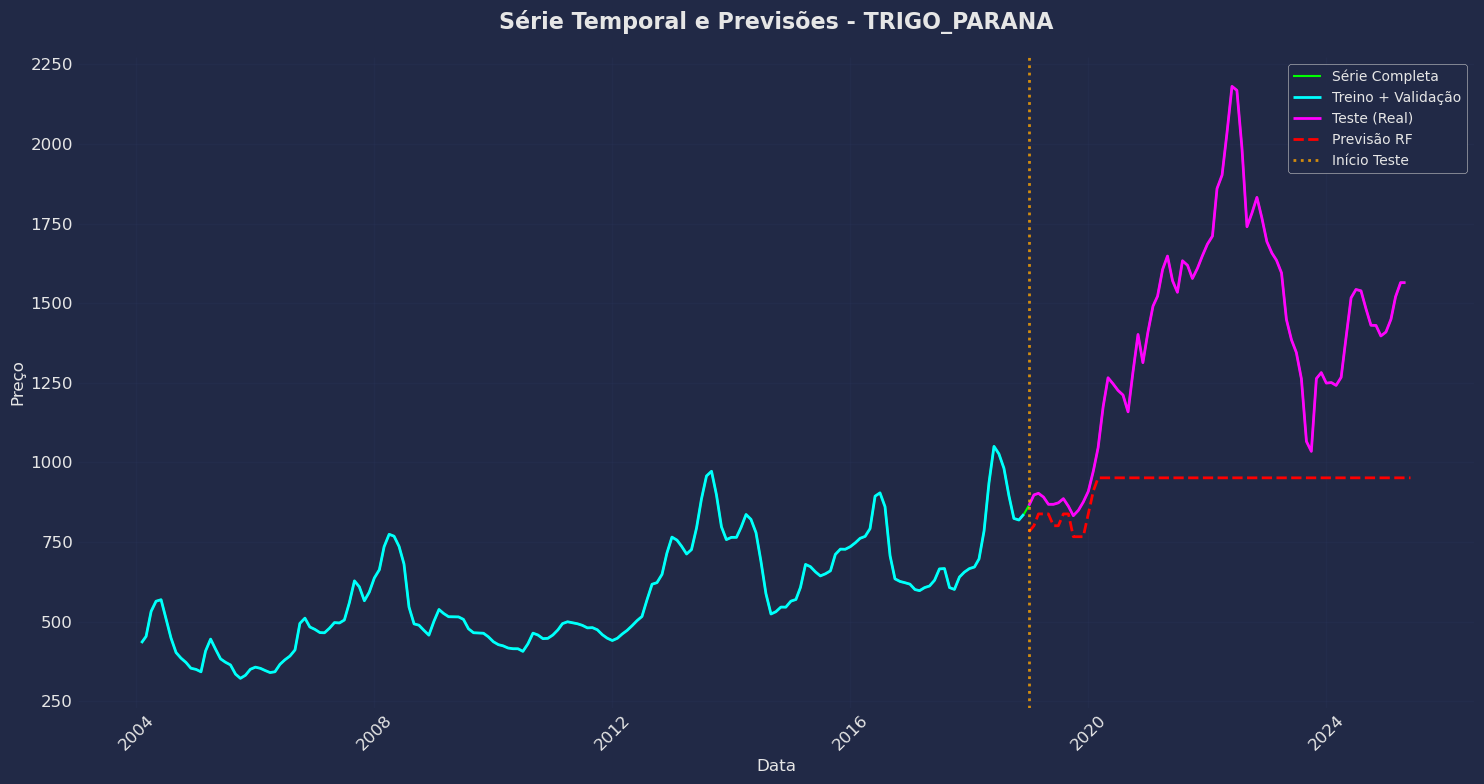

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


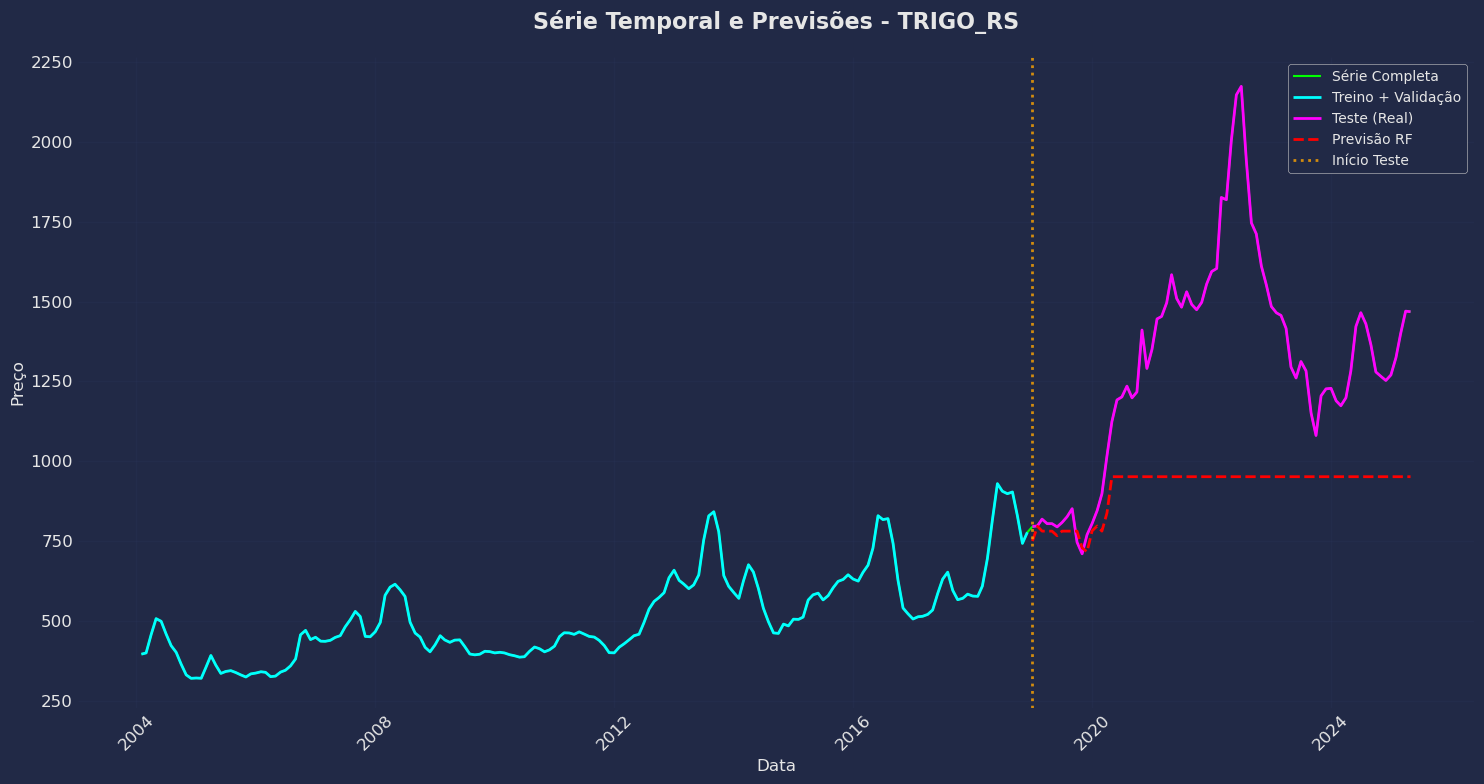

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [11]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lime', linewidth=1.5, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='cyan', linewidth=2, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='fuchsia', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['rf'], 
                color='red', linewidth=2, linestyle='--', label='Previsão RF')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)

### Tunned

In [12]:
def mae_from_forecasts(forecasts_df, actual_df, model_col='rf'):
    df = forecasts_df.merge(actual_df[['unique_id','ds','y']], 
                            on=['unique_id','ds'], how='inner')
    if len(df) == 0:
        return np.inf
    return mean_absolute_error(df['y'], df[model_col])

In [13]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 200)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    max_depth = trial.suggest_categorical("max_depth", [None, 2, 5, 10, 20, 30, 50])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    criterion = trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])
    
    # modelo pipeline com MinMaxScaler
    model = make_pipeline(
        MinMaxScaler(feature_range=(0,1)),
        RandomForestRegressor(
            n_estimators=n_estimators,
            criterion=criterion,
            min_samples_leaf=min_samples_leaf,
            max_depth=max_depth,
            bootstrap=bootstrap
        )
    )
    
    fcst = MLForecast(models={'rf': model}, lags=lags, freq='MS')
    fcst.fit(train)
    
    preds = []
    for i in range(len(val)):
        f_next = fcst.predict(h=1)
        preds.append(f_next)
        obs = val.iloc[[i]][['unique_id','ds','y']]
        fcst.update(obs)
    
    forecasts_df = pd.concat(preds, ignore_index=True)
    mae = mae_from_forecasts(forecasts_df, val, model_col='rf')
    
    return mae

# https://www.sciencedirect.com/science/article/pii/S3050700625000040?via%3Dihub
# https://onlinelibrary.wiley.com/doi/full/10.1002/isaf.1459
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10908409&tag=1
# https://www.nature.com/articles/s41598-024-74503-4#Tab7
# https://www.mdpi.com/2227-9091/11/2/27

In [14]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)

study.optimize(objective, n_trials=80, n_jobs=1)

print("Melhor score (val):", study.best_value)
print("Melhores hiperparâmetros:", study.best_params)

[I 2025-10-07 09:39:02,151] A new study created in memory with name: no-name-1e7f7428-ba5d-4759-ae63-cb411ee38226


[I 2025-10-07 09:39:08,992] Trial 0 finished with value: 14.084888207702248 and parameters: {'n_estimators': 78, 'min_samples_leaf': 10, 'max_depth': 30, 'bootstrap': True, 'criterion': 'squared_error'}. Best is trial 0 with value: 14.084888207702248.
[I 2025-10-07 09:39:14,341] Trial 1 finished with value: 17.478550966419004 and parameters: {'n_estimators': 40, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': False, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 14.084888207702248.
[I 2025-10-07 09:39:20,747] Trial 2 finished with value: 11.2545240130968 and parameters: {'n_estimators': 124, 'min_samples_leaf': 3, 'max_depth': 5, 'bootstrap': True, 'criterion': 'friedman_mse'}. Best is trial 2 with value: 11.2545240130968.
[I 2025-10-07 09:39:28,320] Trial 3 finished with value: 17.506360890192454 and parameters: {'n_estimators': 134, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': False, 'criterion': 'poisson'}. Best is trial 2 with value: 11.2545240130968.
[I 202

Melhor score (val): 5.932518921326721
Melhores hiperparâmetros: {'n_estimators': 13, 'min_samples_leaf': 7, 'max_depth': 30, 'bootstrap': True, 'criterion': 'absolute_error'}


In [15]:
best = study.best_params
rf_best = RandomForestRegressor(
        n_estimators=best['n_estimators'],
        criterion=best['criterion'],
        min_samples_leaf=best['min_samples_leaf'],
        max_depth=best['max_depth'],
        bootstrap=best['bootstrap'],
        random_state=42
    )
model_best = make_pipeline(MinMaxScaler(feature_range=(0,1)), rf_best)

fcst_final = MLForecast(models={'rf': model_best}, lags=lags, freq='MS')
fcst_final.fit(full_train)

MLForecast(models=[rf], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

In [16]:
import os
import joblib

SAVE_DIR = "/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/"

# Garante que o diretório exista
os.makedirs(SAVE_DIR, exist_ok=True)

def save_model(model, name: str):
    """
    Salva modelos de sklearn, keras e pmdarima no formato adequado.

    Parâmetros:
    - model: objeto do modelo treinado
    - name: nome do arquivo (sem extensão)
    """
    path = os.path.join(SAVE_DIR, name)

    joblib.dump(model, f"{path}.pkl")
    print(f"✅ Modelo sklearn salvo em: {path}.pkl")

save_model(fcst_final, "rf_tunned")

✅ Modelo sklearn salvo em: /home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/rf_tunned.pkl


In [17]:
forecasts = []
for i in range(len(test)):
    f_next = fcst_final.predict(h=1)
    forecasts.append(f_next)
    obs = test.iloc[[i]][['unique_id','ds','y']]
    fcst_final.update(obs)

forecasts_df = pd.concat(forecasts, ignore_index=True)

In [18]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['rf'],         
    groupby_column='unique_id'     
)
print(results)
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)

         unique_id Model  n_observations         MAE      MAPE           MSE  \
0    ACUCAR_SANTOS    rf              20    8.058216  0.054975    116.703015   
1        ACUCAR_SP    rf             100    4.292630  0.038304     36.810598   
2          ALGODAO    rf             205   12.238074  0.034416    397.280293   
3            ARROZ    rf             277    2.209521  0.036777     12.980669   
4     CAFE_ARABICA    rf             381   68.558642  0.053795  57435.214691   
5     CAFE_ROBUSTA    rf             468   46.822172  0.091815  18100.638307   
6            MILHO    rf             543    2.265936  0.051670      6.739782   
7      SOJA_PARANA    rf             644    4.267836  0.054933     21.641716   
8   SOJA_PARANAGUA    rf             714    8.586345  0.097779     77.299388   
9     TRIGO_PARANA    rf             791  104.967556  0.094786  41580.878475   
10        TRIGO_RS    rf             868   70.756013  0.065072  28521.667716   

          RMSE        R2  
0    10.8029

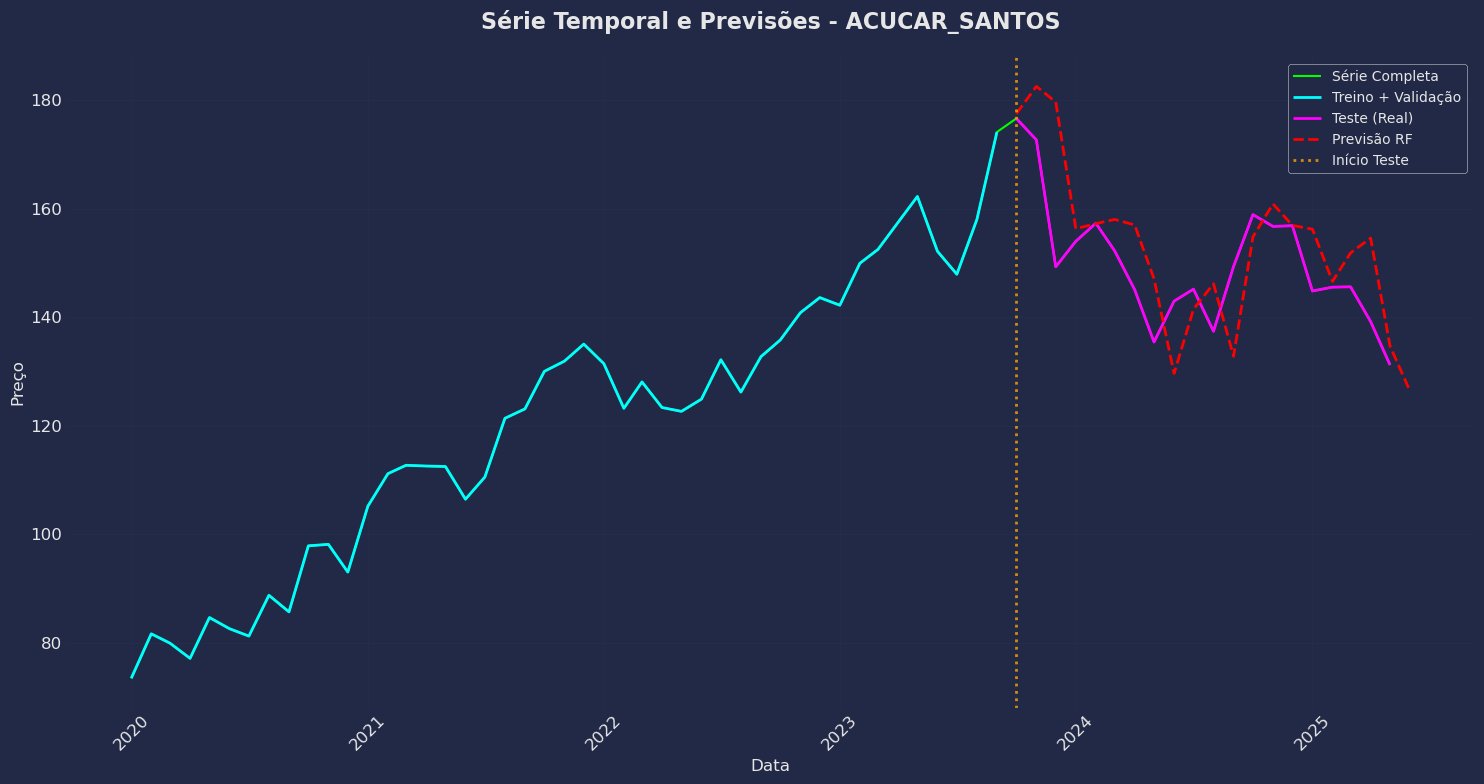

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


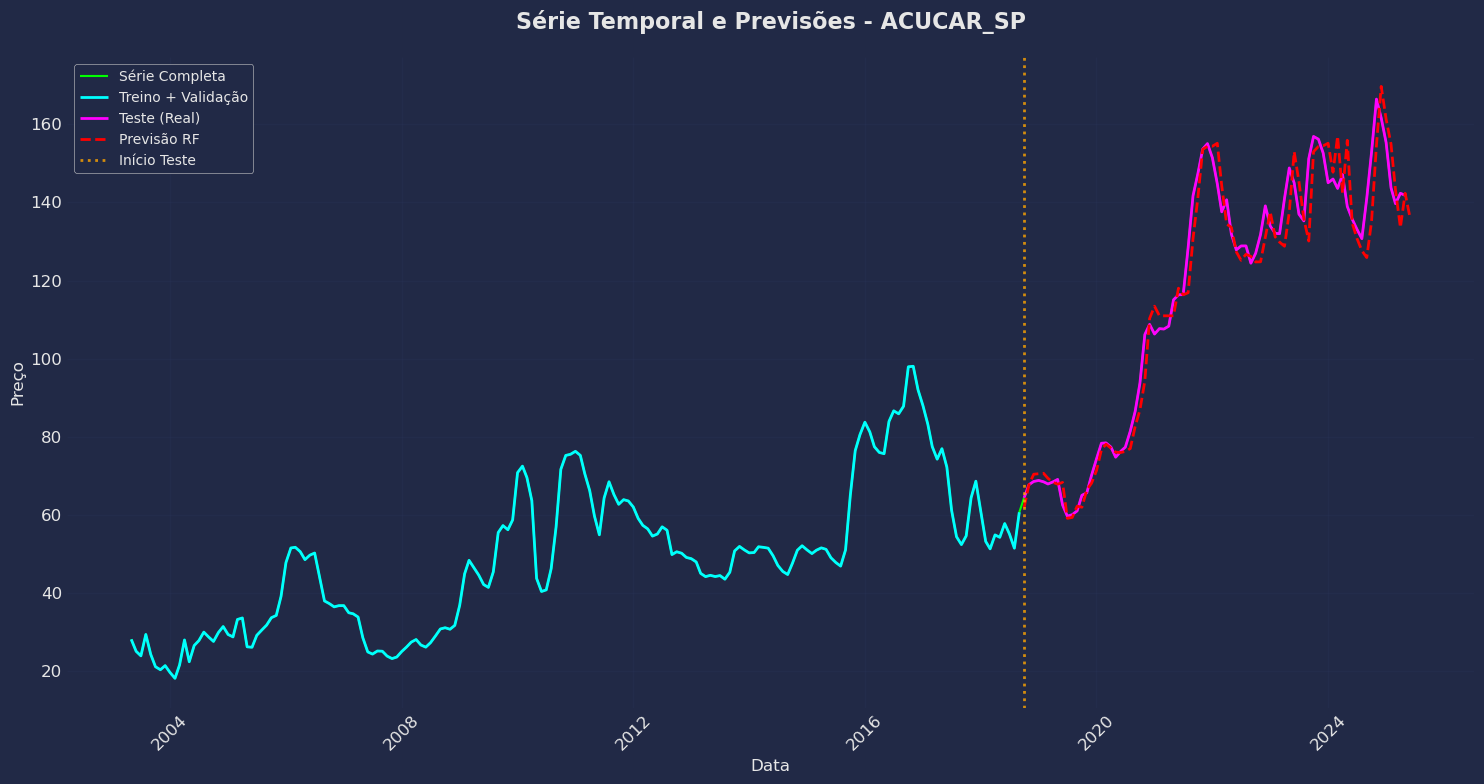

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


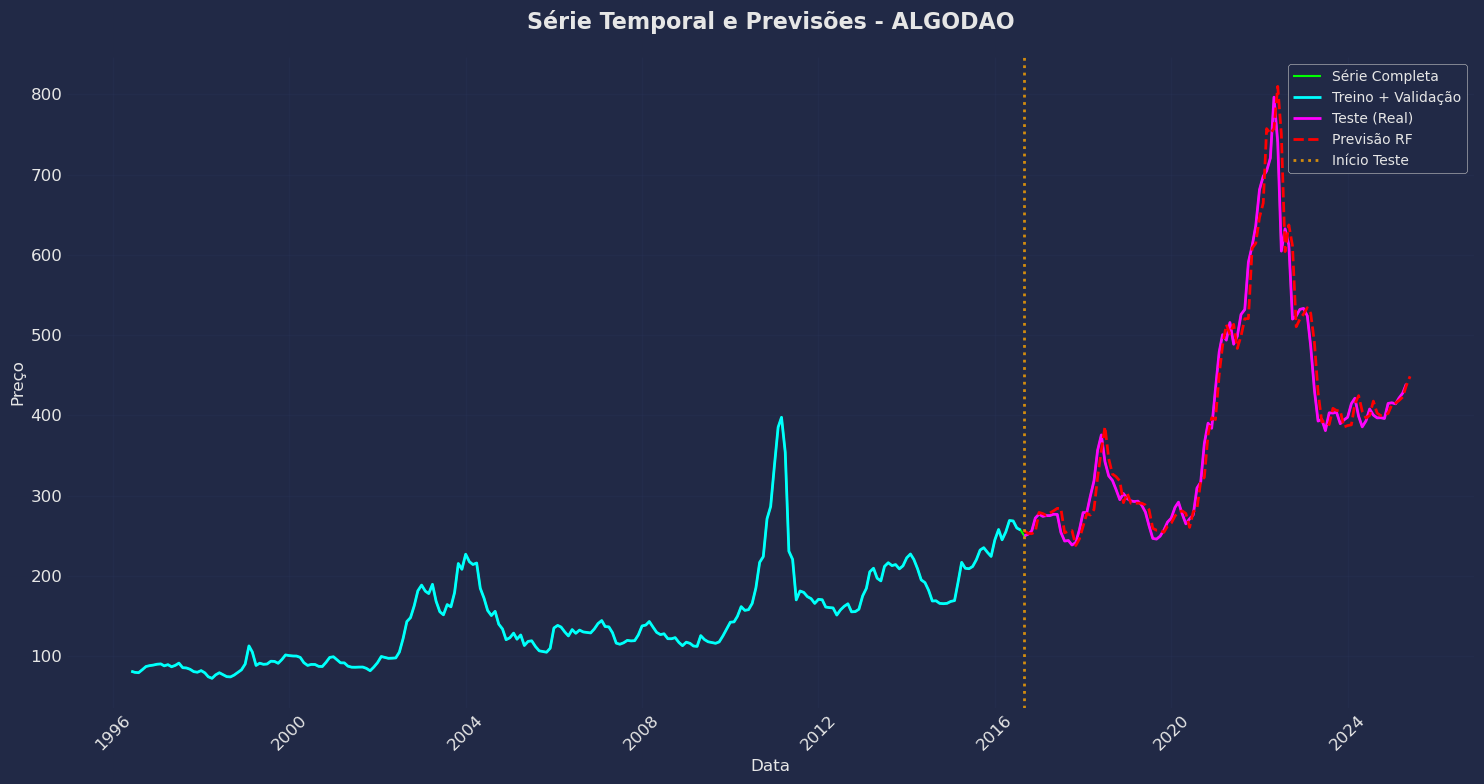

Gráfico exibido para: ALGODAO
--------------------------------------------------


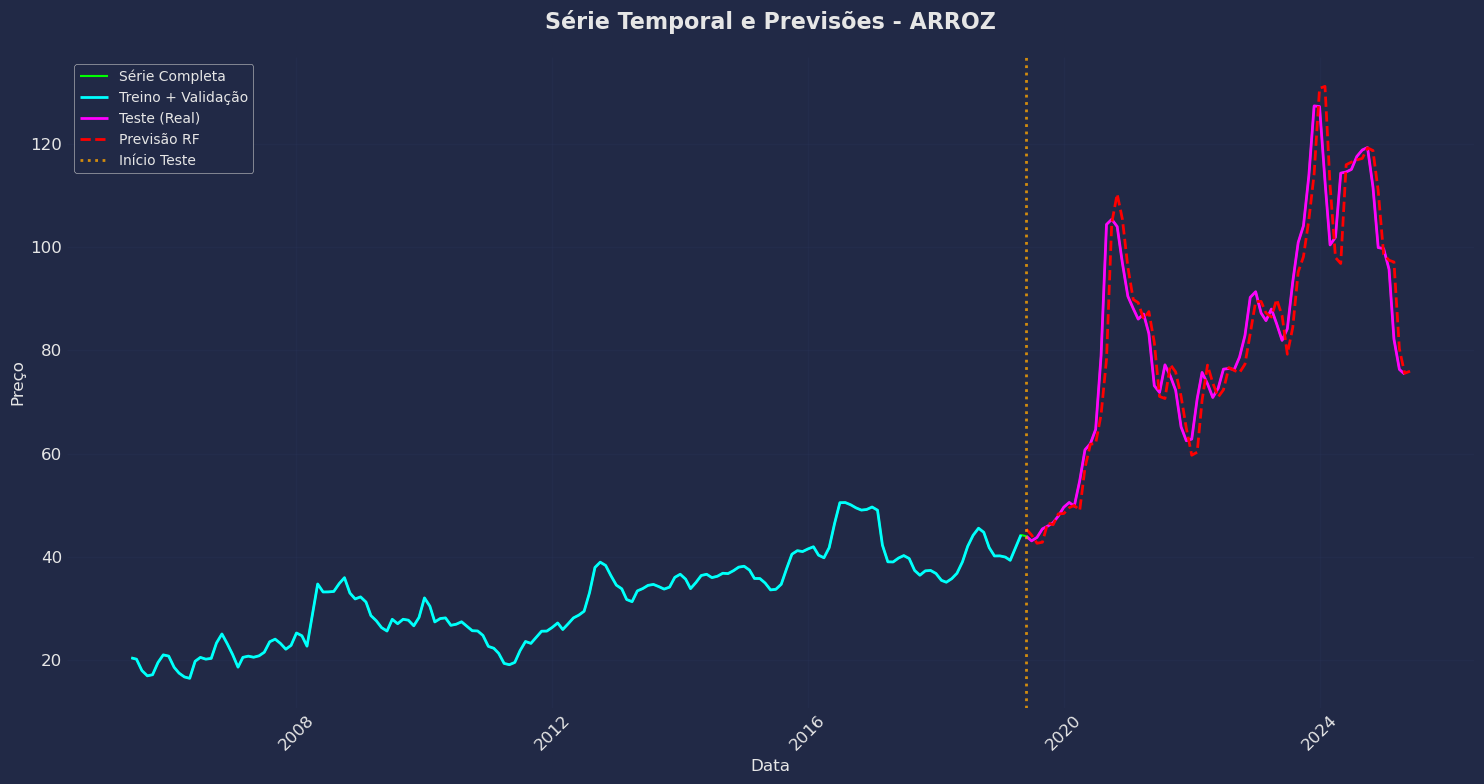

Gráfico exibido para: ARROZ
--------------------------------------------------


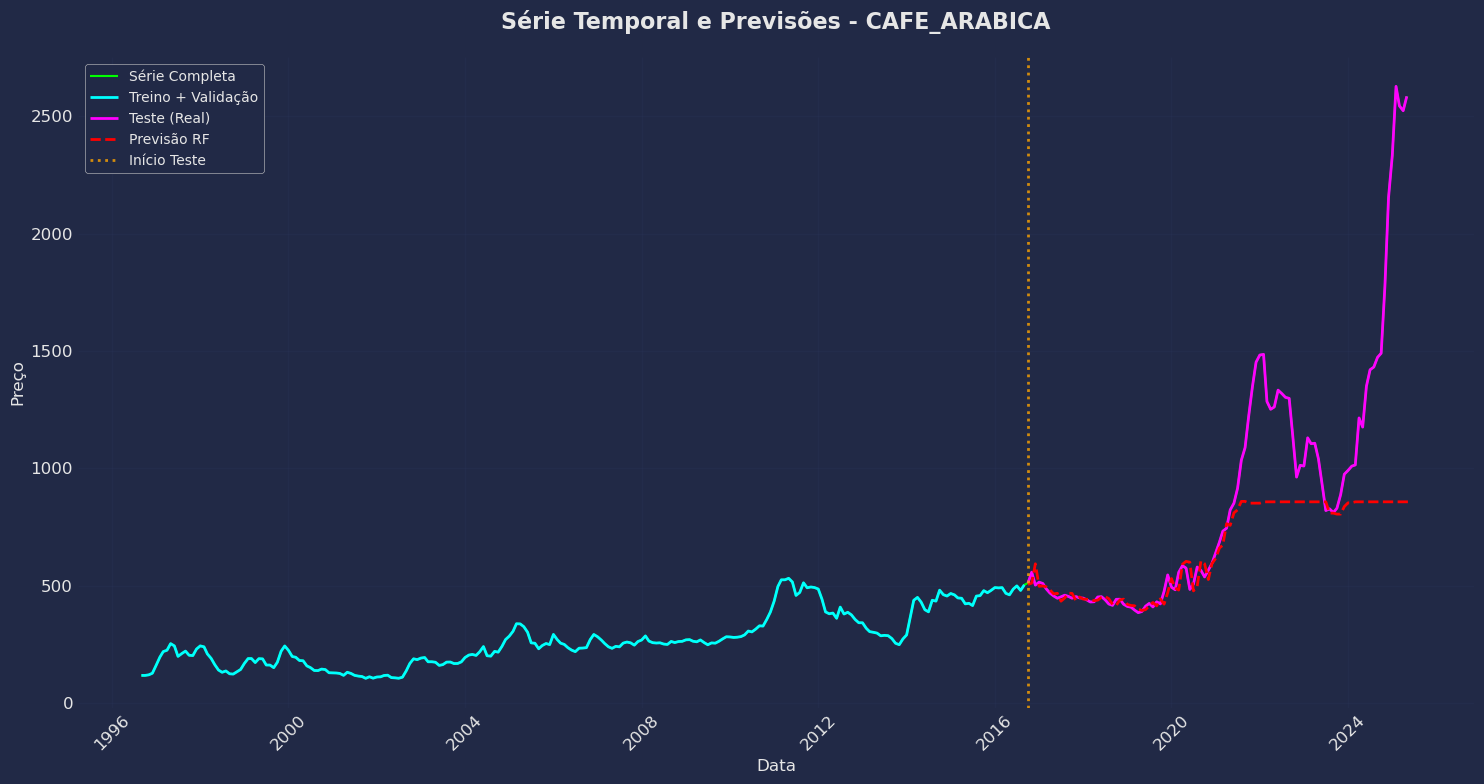

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


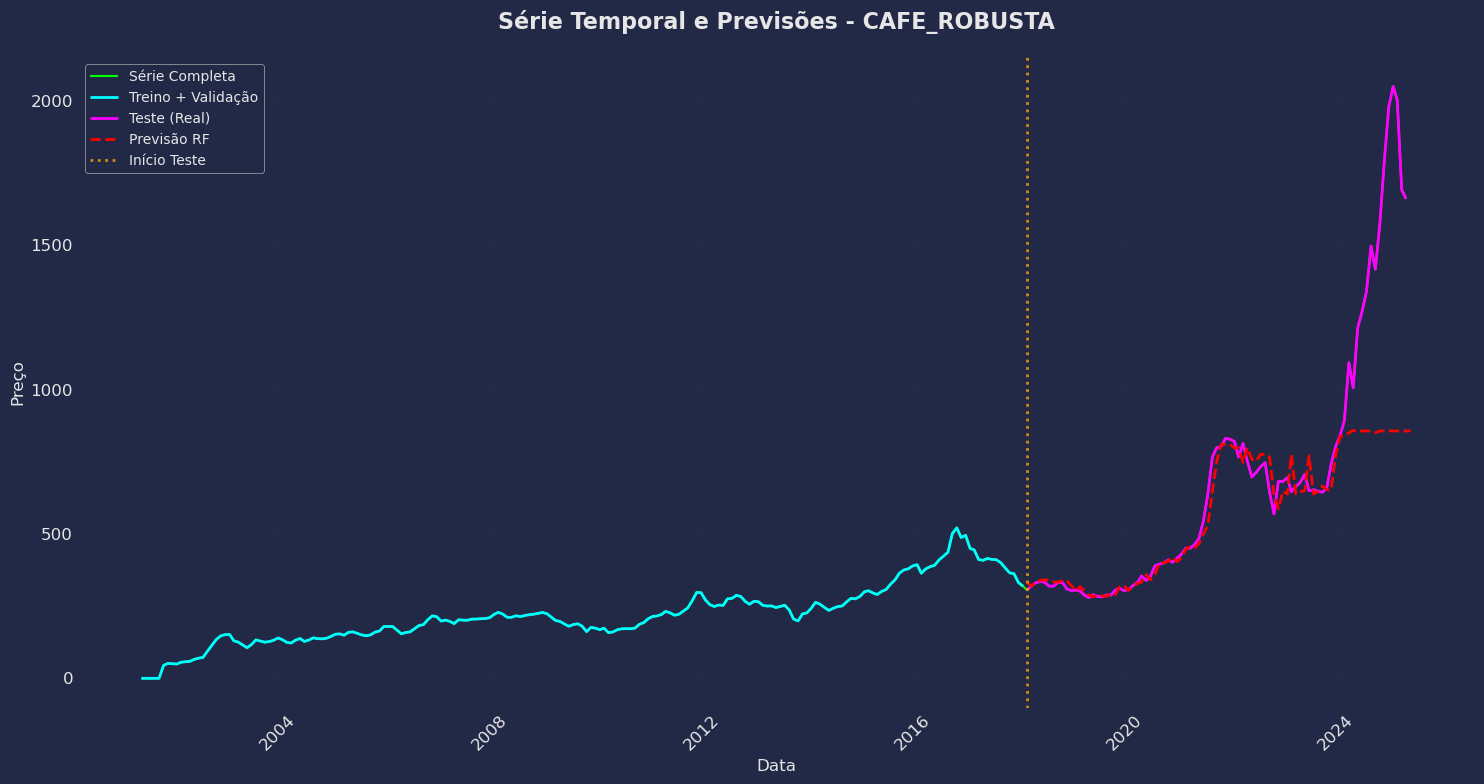

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


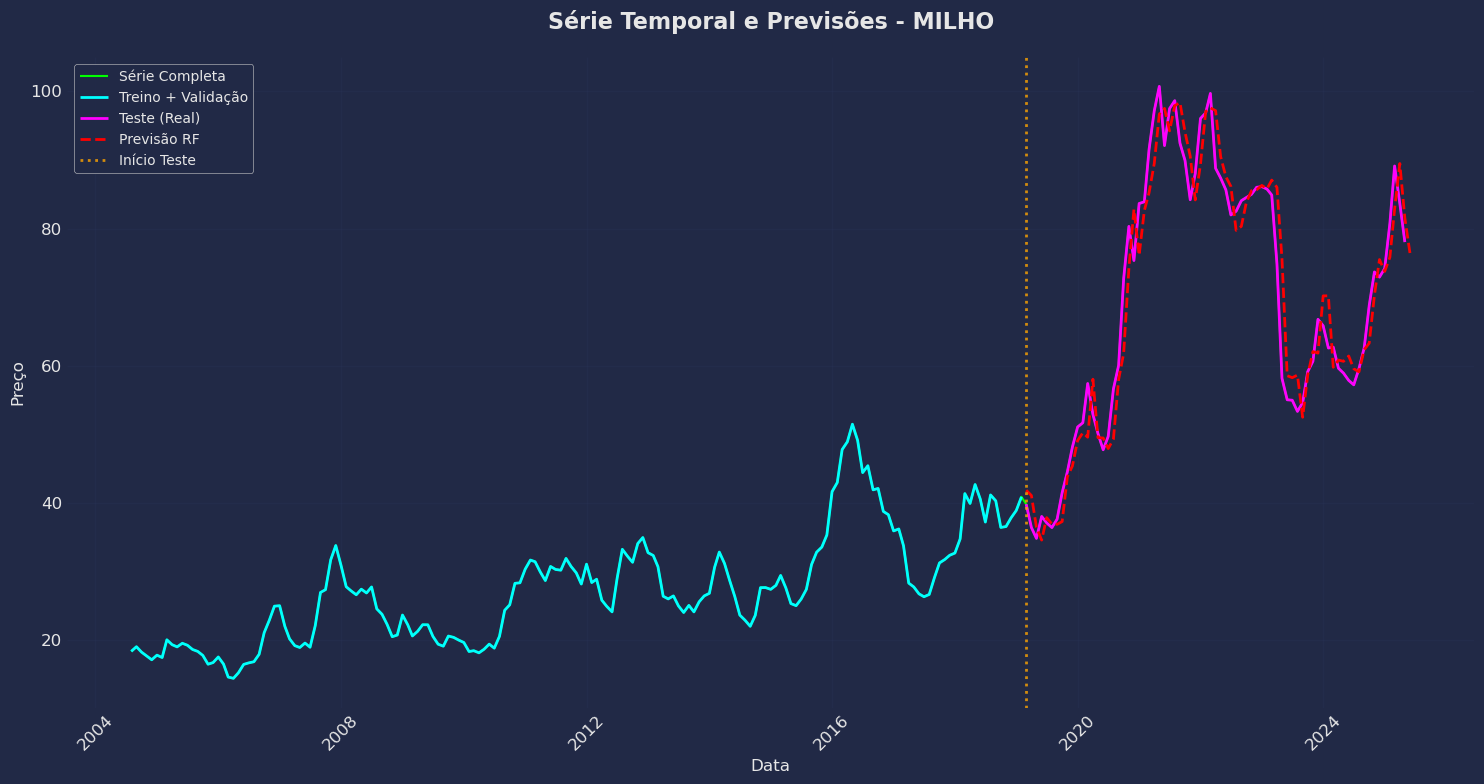

Gráfico exibido para: MILHO
--------------------------------------------------


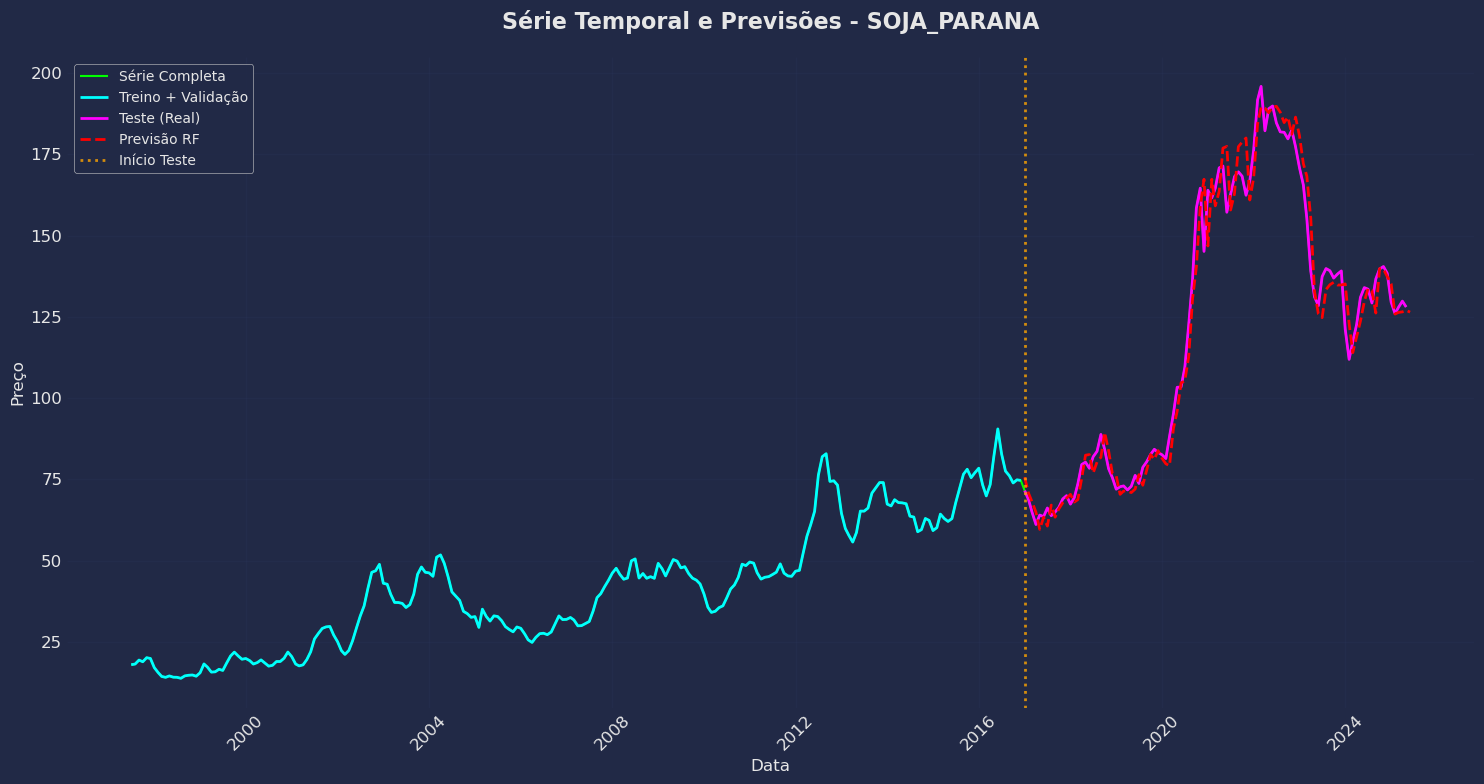

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


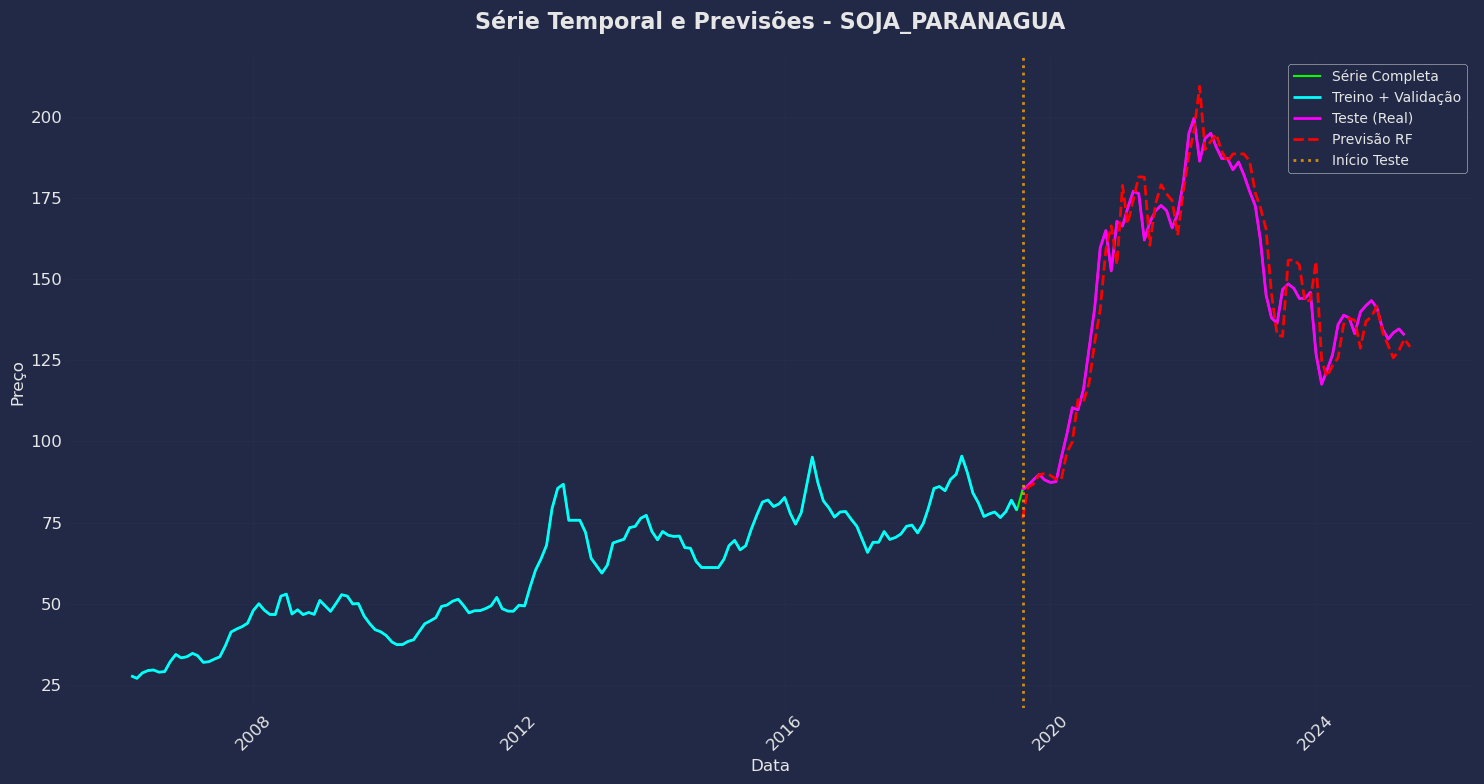

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


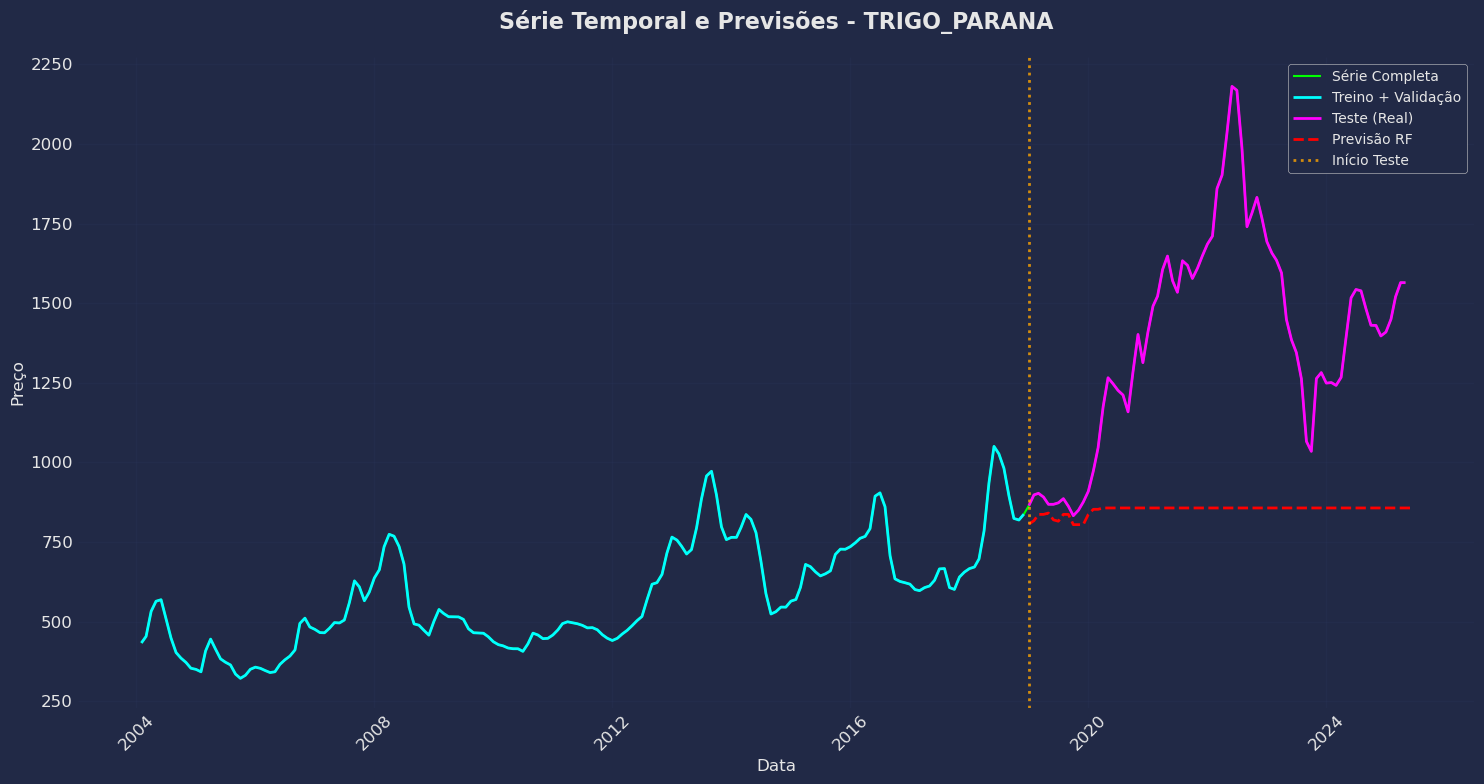

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


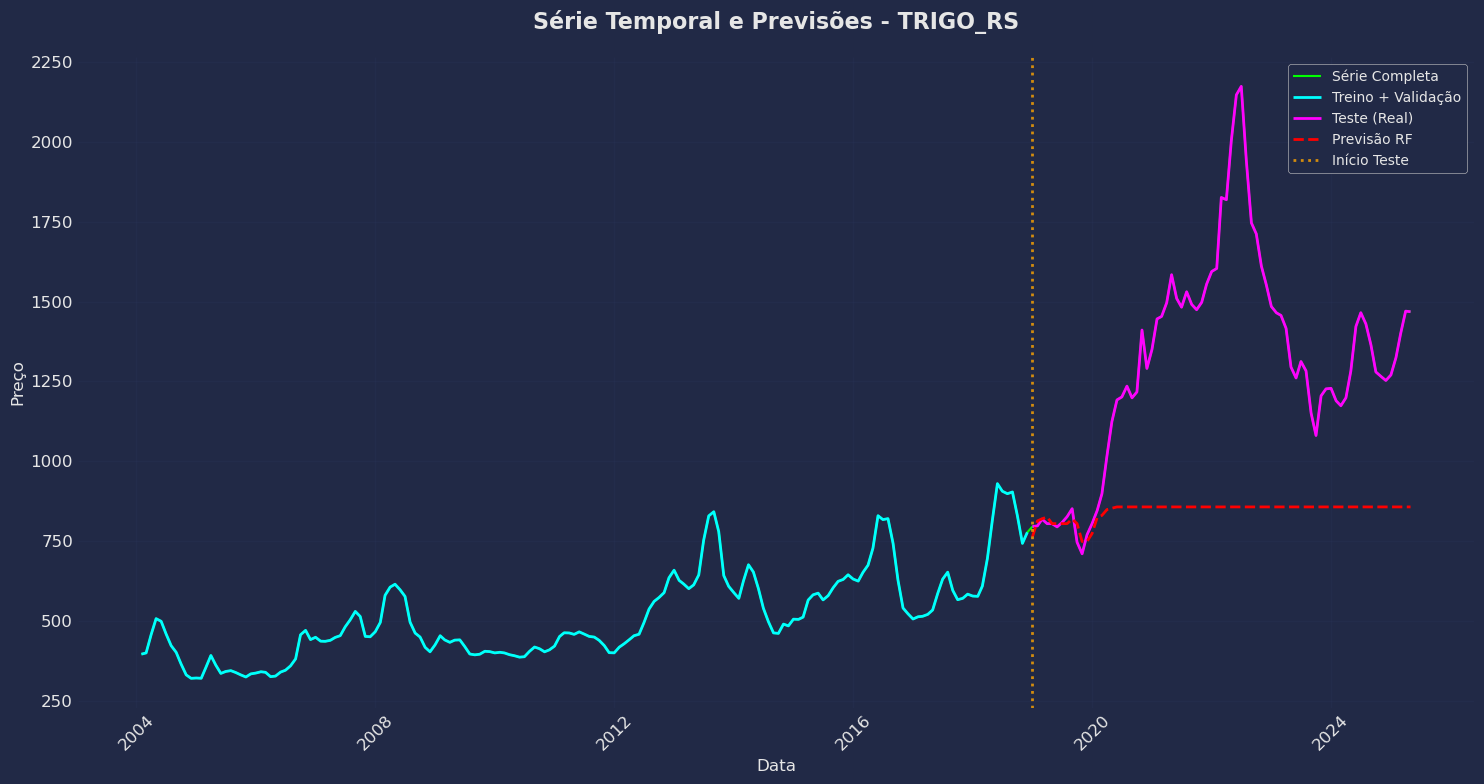

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [19]:
plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)